# Report of WaveNet-Implementation

## Background

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
tex2jax: {
inlineMath: [['$', '$'], ['\\(', '\\)']],
processEscapes: true
}
});
</script>
<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=TeX-MML-AM_CHTML"></script>

Stated broadly, the goal of this model is to predict future audio based on past audio given. We can formalize this goal slightly by rephrazing it to the following:  

Given a sequence of data $(x_1, x_2, x_3, \ldots, x_{n-1}, x_n)$

We'd like to predict the next term of the sequence, that is, $x_{n+1}$

In our case, our sequence is an audio signal.

## Contribution

This is a modification of **[Vincent Herrmann's](https://github.com/vincentherrmann/pytorch-wavenet)** implementation of the **[WaveNet Architecture](https://arxiv.org/abs/1609.03499)**. The extent of the modifications are as follows:
* Created a separate dataset in train_samples/dataset.npz, encoded from train_samples/emil-telmanyi_bwv1003.wav. This .wav file was sourced from **[This github repository](https://github.com/salu133445/bach-violin-dataset/tree/main/bach-violin/audio/emil-telmanyi)**

* In `audio_data.py`, I changed `WavenetDataset.create_dataset()` to use scipy.signal and soundfile for mu-law encoding, rather than librosa
  
* In `model_logger.py`, in `TensorBoardLogger`, I changed some of the `tensorflow.summary` objects to instead be `tensorflow.compat.v1.summary objects`. The purpose of `tensorflow.compat.v1` is to allow us to continue to use objects and methods from before tensorflow 2.0 (backwards compatibility option)

* In `wavenet_training.py`, in `WaveNetTrainer.train()`, I changed `num_workers` to 0 for `self.dataloader`. This is because I ran into pickling / serialization issues when I tried to use multiprocessing. I will mention the implications of this later in the report.

* In `wavenet_modules.py`, I changed the `ConstantPad1d` class to work with a newer version of `torch.autograd.Function`.

* Changed various objects in the code that were set to run on the CPU to instead run on GPU, specifically by setting their device to "cuda"

## Encoding
Data for WaveNet first goes through mu-law encoding, ensuring that quieter sounds become more pronounced so that they'll still be picked up. Our signal then gets scaled to lie between 0 and 255, before being separated and placed into 256 different bins. This allows WaveNet to treat predicting future audio as a classification problem (given a sequence of data, each term being one of 256 categories, predict which of the 256 categories the next term will be).

In [1]:
import numpy as np
import torch
from wavenet_model import *
from audio_data import WavenetDataset 
from wavenet_training import *
from model_logging import *
import tensorflow as tf

### Visualizing mu-law Encoding on 1/16 th Second of Audio

The sample rate of this file is 16000 Hz
The number of tokens is 1000000 tokens
Visualizing mu-law encoding on the first 1000 items


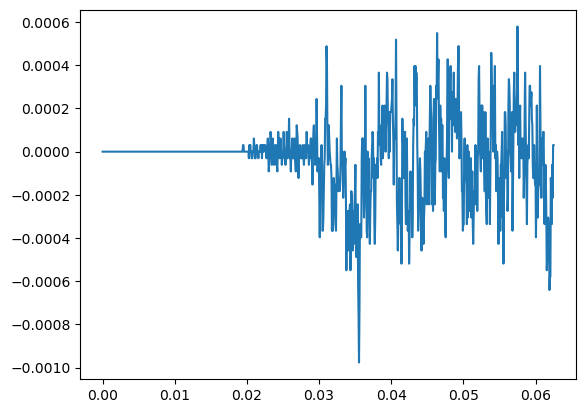

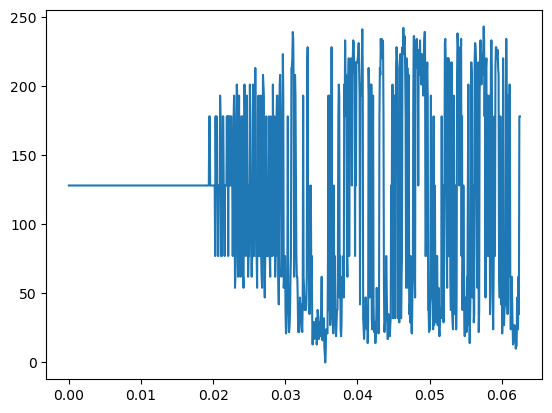

In [40]:
def mu_law_encoding(audio):
    # number of bins at the end which we will sort the audio into. This is a hyperparameter
    mu = 255 

    # normalizing the audio to lie in the interval [-1, 1]
    normalized_audio = audio / np.max(np.abs(audio)) 

    # due to rounding errors, there could still be audio not in [-1, 1] after normalization
    safe_audio = np.clip(normalized_audio, -1, 1) 

    # This implements the mu-law encoding
    new_signal = np.sign(safe_audio) * (np.log(1+mu*np.abs(safe_audio))) / (np.log(1 + mu))
    
    # note that casting as an integer is the same as math.floor() for positive values
    quantized = ( ((new_signal+1)/2)*mu + 0.5).astype(np.int32)
    
    return quantized

audio_data, sample_rate = sf.read('train_samples/emil-telmanyi_bwv1003.wav')
print(f"The sample rate of this file is {sample_rate} Hz")
audio_data = audio_data[:1000000] # we want 1M tokens
print(f"The number of tokens is {len(audio_data)} tokens")

# only need to save the file once!
# np.savez('train_samples/dataset.npz', *[audio_data])

print("Visualizing mu-law encoding on the first 1000 items")

audio_data = audio_data[:1000]
encoded_data = mu_law_encoding(audio_data)
time = np.linspace(0, len(audio_data) / sample_rate, len(audio_data)) 

# visualization of the encoding
plt.subplots()
plt.plot(time, audio_data)
plt.figure()
plt.plot(time, encoded_data)

## Training and Generating

I ran into several problems while training, mostly centered around hardware. I struggled to become comfortable with my university's HPC, and due to time constraints decided to instead train my model locally on my desktop. Thankfully I could still use cuda on this device, however as mentioned in the **Contributions** section, I set `num_workers` to 0. This is because I ran into multiprocessing errors being thrown, and in the interest of time decided that I'd rather not use multiprocessing. This decision led me to reduce the number of samples I decided to train with. I chose to use every __64th__ sample from my dataset of 1 Million tokens, afterwards giving me __15609__ samples which I would train with. I chose to use a batch size of 4, and ran my training across the entire 15609 samples twice, resulting in 2 epochs.


Thankfully the original repository has model snapshots, which contain all the parameter information. These are saved incrementally along the way during training.

In [3]:
data = WavenetDataset(dataset_file='train_samples/dataset.npz',
                      item_length=3070 + 16 - 1,
                      target_length=16,
                      file_location='train_samples',
                      test_stride=64) # we only consider every 64th token
print('the dataset has ' + str(len(data)) + ' items')
print(f'{data[100][0].shape}')

one hot input
the dataset has 61335 items
torch.Size([256, 3085])


### Generated Results

In [10]:
start_data = data[25000][0] # we'll be generating from past audio from the same dataset we trained on
print(len(start_data))
start_data = torch.max(start_data, 0)[1] # convert one hot vectors to integers

def prog_callback(step, total_steps):
    print(str(100 * step // total_steps) + "% generated")
model = load_latest_model_from('snapshots', use_cuda=True)
generated = model.generate_fast(num_samples=160000,
                                 first_samples=start_data,
                                 progress_callback=prog_callback,
                                 progress_interval=1000,
                                 temperature=1.0,
                                 regularize=0.)

256
load model snapshots/chaconne_model_2025-05-04_02-14-36
0% generated
0% generated
1% generated
1% generated
one generating step does take approximately 0.024953076839447023 seconds)
2% generated
3% generated
3% generated
4% generated
4% generated
5% generated
6% generated
6% generated
7% generated
7% generated
8% generated
9% generated
9% generated
10% generated
11% generated
11% generated
12% generated
12% generated
13% generated
14% generated
14% generated
15% generated
15% generated
16% generated
17% generated
17% generated
18% generated
19% generated
19% generated
20% generated
20% generated
21% generated
22% generated
22% generated
23% generated
23% generated
24% generated
25% generated
25% generated
26% generated
26% generated
27% generated
28% generated
28% generated
29% generated
30% generated
30% generated
31% generated
31% generated
32% generated
33% generated
33% generated
34% generated
34% generated
35% generated
36% generated
36% generated
37% generated
38% generated
3

In [13]:
# recall that our audio is 16KHz
import IPython.display as ipd

ipd.Audio(generated, rate=16000)

In [15]:
import scipy.io.wavfile as wf
generated = generated / np.max(np.abs(generated))

# convert to signed 16-bit integers (16-bit depth)
int_generated = (generated * 32767).astype(np.int16)

# only need to write the file once!
# write to .wav file
# wf.write("generated_sample_16_bit.wav", 16000, int_generated)

### Log Results from Training

The step-loss results and the step-accuracy both seem to suggest that my model was overfitting. In hindsight, my data wasn't the most varied, considering it all came from 1 minute of audio. Perhaps I could have sampled across the entire .wav file, and used a larger stride. For example, taking every 1024'th sample instead of every 64'th sample.

In [2]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator(
    "logs/model",
    size_guidance={event_accumulator.SCALARS: 0},  # size_load all scalars
)

ea.Reload()

print(ea.Tags()["scalars"])



['loss', 'validation loss', 'validation accuracy']


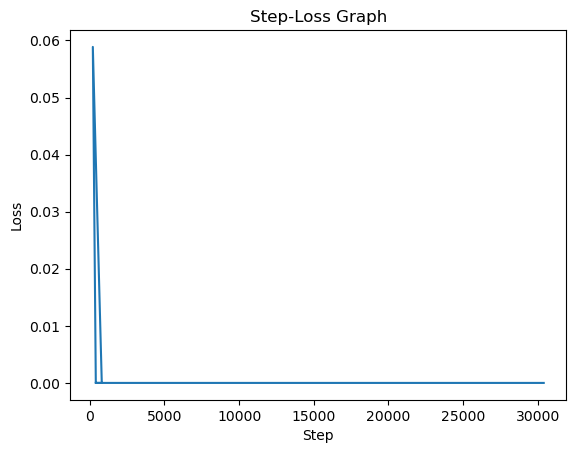

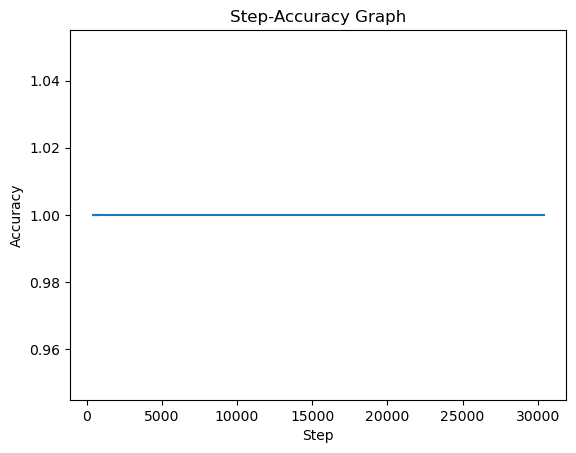

In [7]:
import matplotlib.pyplot as plt

step_loss = []
loss = []
for i in ea.Scalars("loss")[6:-1]:
    step_loss.append(i.step)
    loss.append(i.value)

step_accuracy = []
accuracy = []
for i in ea.Scalars("validation accuracy"):
    step_accuracy.append(i.step)
    accuracy.append(i.value)


plt.subplots()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Step-Loss Graph')
plt.plot(step_loss, loss)

plt.figure()
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Step-Accuracy Graph')
plt.plot(step_accuracy, accuracy)

## Next Steps

Although I could train this model on more varied data to try and get a better result, to be honest I'm more curious about other types of architecture which have both better performance as well as faster computation. If I could find a type of model that is able to do real-time generation, that would be more worthwhile in my opinion to implement.